Simple gradient-based quadratic classification model to compute $W$. 

I suspect we'd get very little out of going for something non-linear or higher dimension. We're already getting almost no change on the off-diagonals, so probably not a whole lot going on beyond pairwise interactions.

In [37]:
# ! pip install scikit-learn matplotlib -q

In [38]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from src.model import initialize_weight_matrix, predict_success_probability, sigmoid

np.set_printoptions(precision=2, suppress=True, linewidth=120)

In [42]:
df = pd.read_csv('../data/synth/encoded_founders_composites.csv')

feature_columns = df.columns[:-3]  
X = df[feature_columns].to_numpy()
y = df['success'].values 

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_norm = X

K = X_norm.shape[1]
W = initialize_weight_matrix(K)
W_init = W.copy()
b = 0

X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.2, random_state=42, shuffle=True
)
# 60% train, 20% val 20% test
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, shuffle=True
)

In [43]:
lr = 0.01       
epochs = 1500   
momentum = 0.9  

In [44]:
vW = np.zeros_like(W)
vb = 0.0

train_loss_history = []
val_loss_history = []
test_loss_history = []
train_acc_history = []
val_acc_history = []
test_acc_history = []

N_train = X_train.shape[0]
eps = 1e-8 

for epoch in range(epochs):

    indices = np.random.permutation(N_train)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    
    # Forward pass 
    scores = np.array([x.T @ W @ x for x in X_train_shuffled])
    logits = scores + b
    probs = sigmoid(logits)
    
    # cel
    loss = -np.mean(y_train_shuffled * np.log(probs + eps) +
                      (1 - y_train_shuffled) * np.log(1 - probs + eps))
    train_loss_history.append(loss)
    
    train_preds = (probs > 0.5).astype(int)
    train_acc = np.mean(train_preds == y_train_shuffled)
    train_acc_history.append(train_acc)
    
    # grad
    diff = probs - y_train_shuffled 
    gradW = np.zeros_like(W)
    for i, x in enumerate(X_train_shuffled):
        gradW += diff[i] * np.outer(x, x)
    gradW /= N_train  
    
    gradb = np.mean(diff)
    
    # momentum
    vW = momentum * vW - lr * gradW
    vb = momentum * vb - lr * gradb
    W += vW
    b += vb
    
    # Enforce symmetry.
    W = 0.5 * (W + W.T)
    
    # Evaluate on test set.
    test_scores = np.array([x.T @ W @ x for x in X_test])
    test_logits = test_scores + b
    test_probs = sigmoid(test_logits)
    test_loss = -np.mean(y_test * np.log(test_probs + eps) +
                         (1 - y_test) * np.log(1 - test_probs + eps))
    test_loss_history.append(test_loss)
    
    test_preds = (test_probs > 0.5).astype(int)
    test_acc = np.mean(test_preds == y_test)
    test_acc_history.append(test_acc)
    
    # Evaluate on validation set.
    val_scores = np.array([x.T @ W @ x for x in X_val])
    val_logits = val_scores + b
    val_probs = sigmoid(val_logits)
    val_loss = -np.mean(y_val * np.log(val_probs + eps) +
                        (1 - y_val) * np.log(1 - val_probs + eps))
    val_loss_history.append(val_loss)
    
    val_preds = (val_probs > 0.5).astype(int)
    val_acc = np.mean(val_preds == y_val)
    val_acc_history.append(val_acc)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss:.4f}, Val Loss = {val_loss:.4f}, Test Loss = {test_loss:.4f}, "
              f"Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, Test Acc = {test_acc:.4f}")


Epoch 0: Train Loss = 15.1575, Val Loss = 15.1918, Test Loss = 14.9826, Train Acc = 0.1510, Val Acc = 0.1465, Test Acc = 0.1585
Epoch 100: Train Loss = 2.0531, Val Loss = 2.1468, Test Loss = 2.0672, Train Acc = 0.7930, Val Acc = 0.7775, Test Acc = 0.7855
Epoch 200: Train Loss = 1.6295, Val Loss = 1.7319, Test Loss = 1.6749, Train Acc = 0.8127, Val Acc = 0.8000, Test Acc = 0.7995
Epoch 300: Train Loss = 1.2632, Val Loss = 1.3702, Test Loss = 1.3180, Train Acc = 0.8178, Val Acc = 0.8035, Test Acc = 0.8050
Epoch 400: Train Loss = 0.8990, Val Loss = 0.9928, Test Loss = 0.9534, Train Acc = 0.8215, Val Acc = 0.8030, Test Acc = 0.8040
Epoch 500: Train Loss = 0.6574, Val Loss = 0.7326, Test Loss = 0.7141, Train Acc = 0.8303, Val Acc = 0.8120, Test Acc = 0.8150
Epoch 600: Train Loss = 0.5313, Val Loss = 0.5888, Test Loss = 0.5873, Train Acc = 0.8347, Val Acc = 0.8210, Test Acc = 0.8165
Epoch 700: Train Loss = 0.4441, Val Loss = 0.4873, Test Loss = 0.4979, Train Acc = 0.8380, Val Acc = 0.8225, T

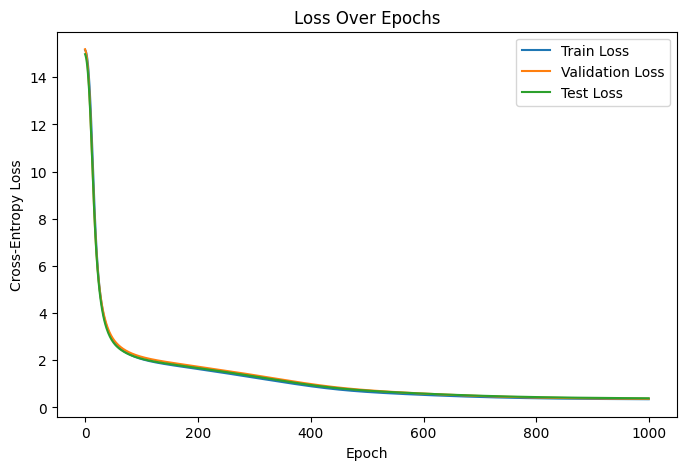

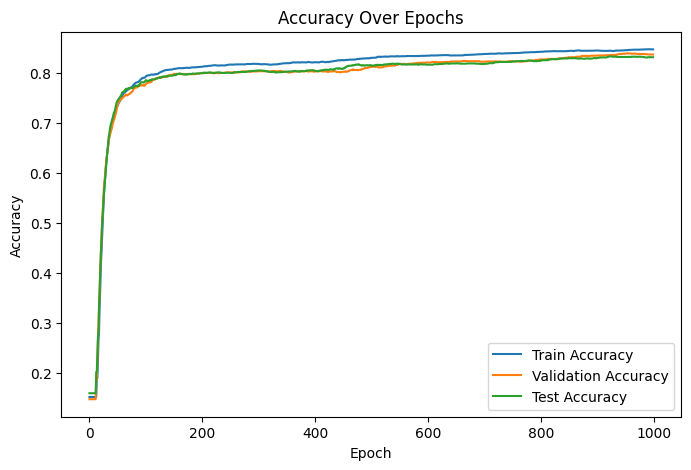

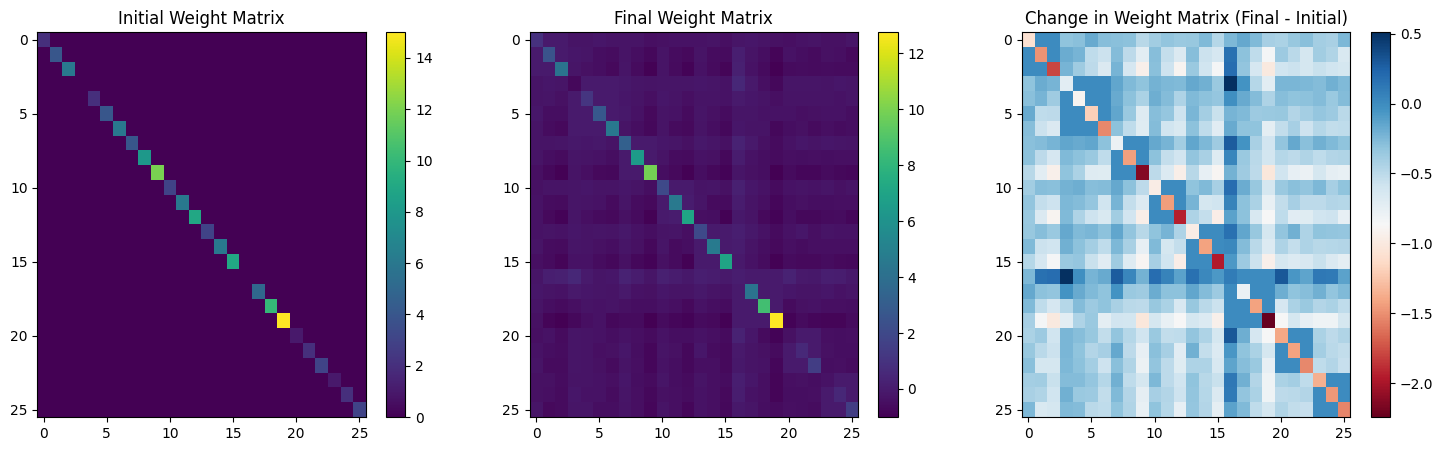

In [ ]:
# Plot training, validation, and test loss curves.
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# %%
# Plot training, validation, and test accuracy curves.
plt.figure(figsize=(8,5))
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.plot(test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

# %%
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
im0 = axs[0].imshow(W_init, aspect='auto', cmap='viridis')
axs[0].set_title("Initial Weight Matrix")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(W, aspect='auto', cmap='viridis')
axs[1].set_title("Final Weight Matrix")
plt.colorbar(im1, ax=axs[1])

W_diff = W - W_init
im2 = axs[2].imshow(W_diff, aspect='auto', cmap='RdBu')
axs[2].set_title("Change in Weight Matrix (Final - Initial)")
plt.colorbar(im2, ax=axs[2])
plt.show()

In [45]:
# print(np.diag(W))
# print(np.diag(W_init))
# print(np.diag(np.abs(W-W_init)))

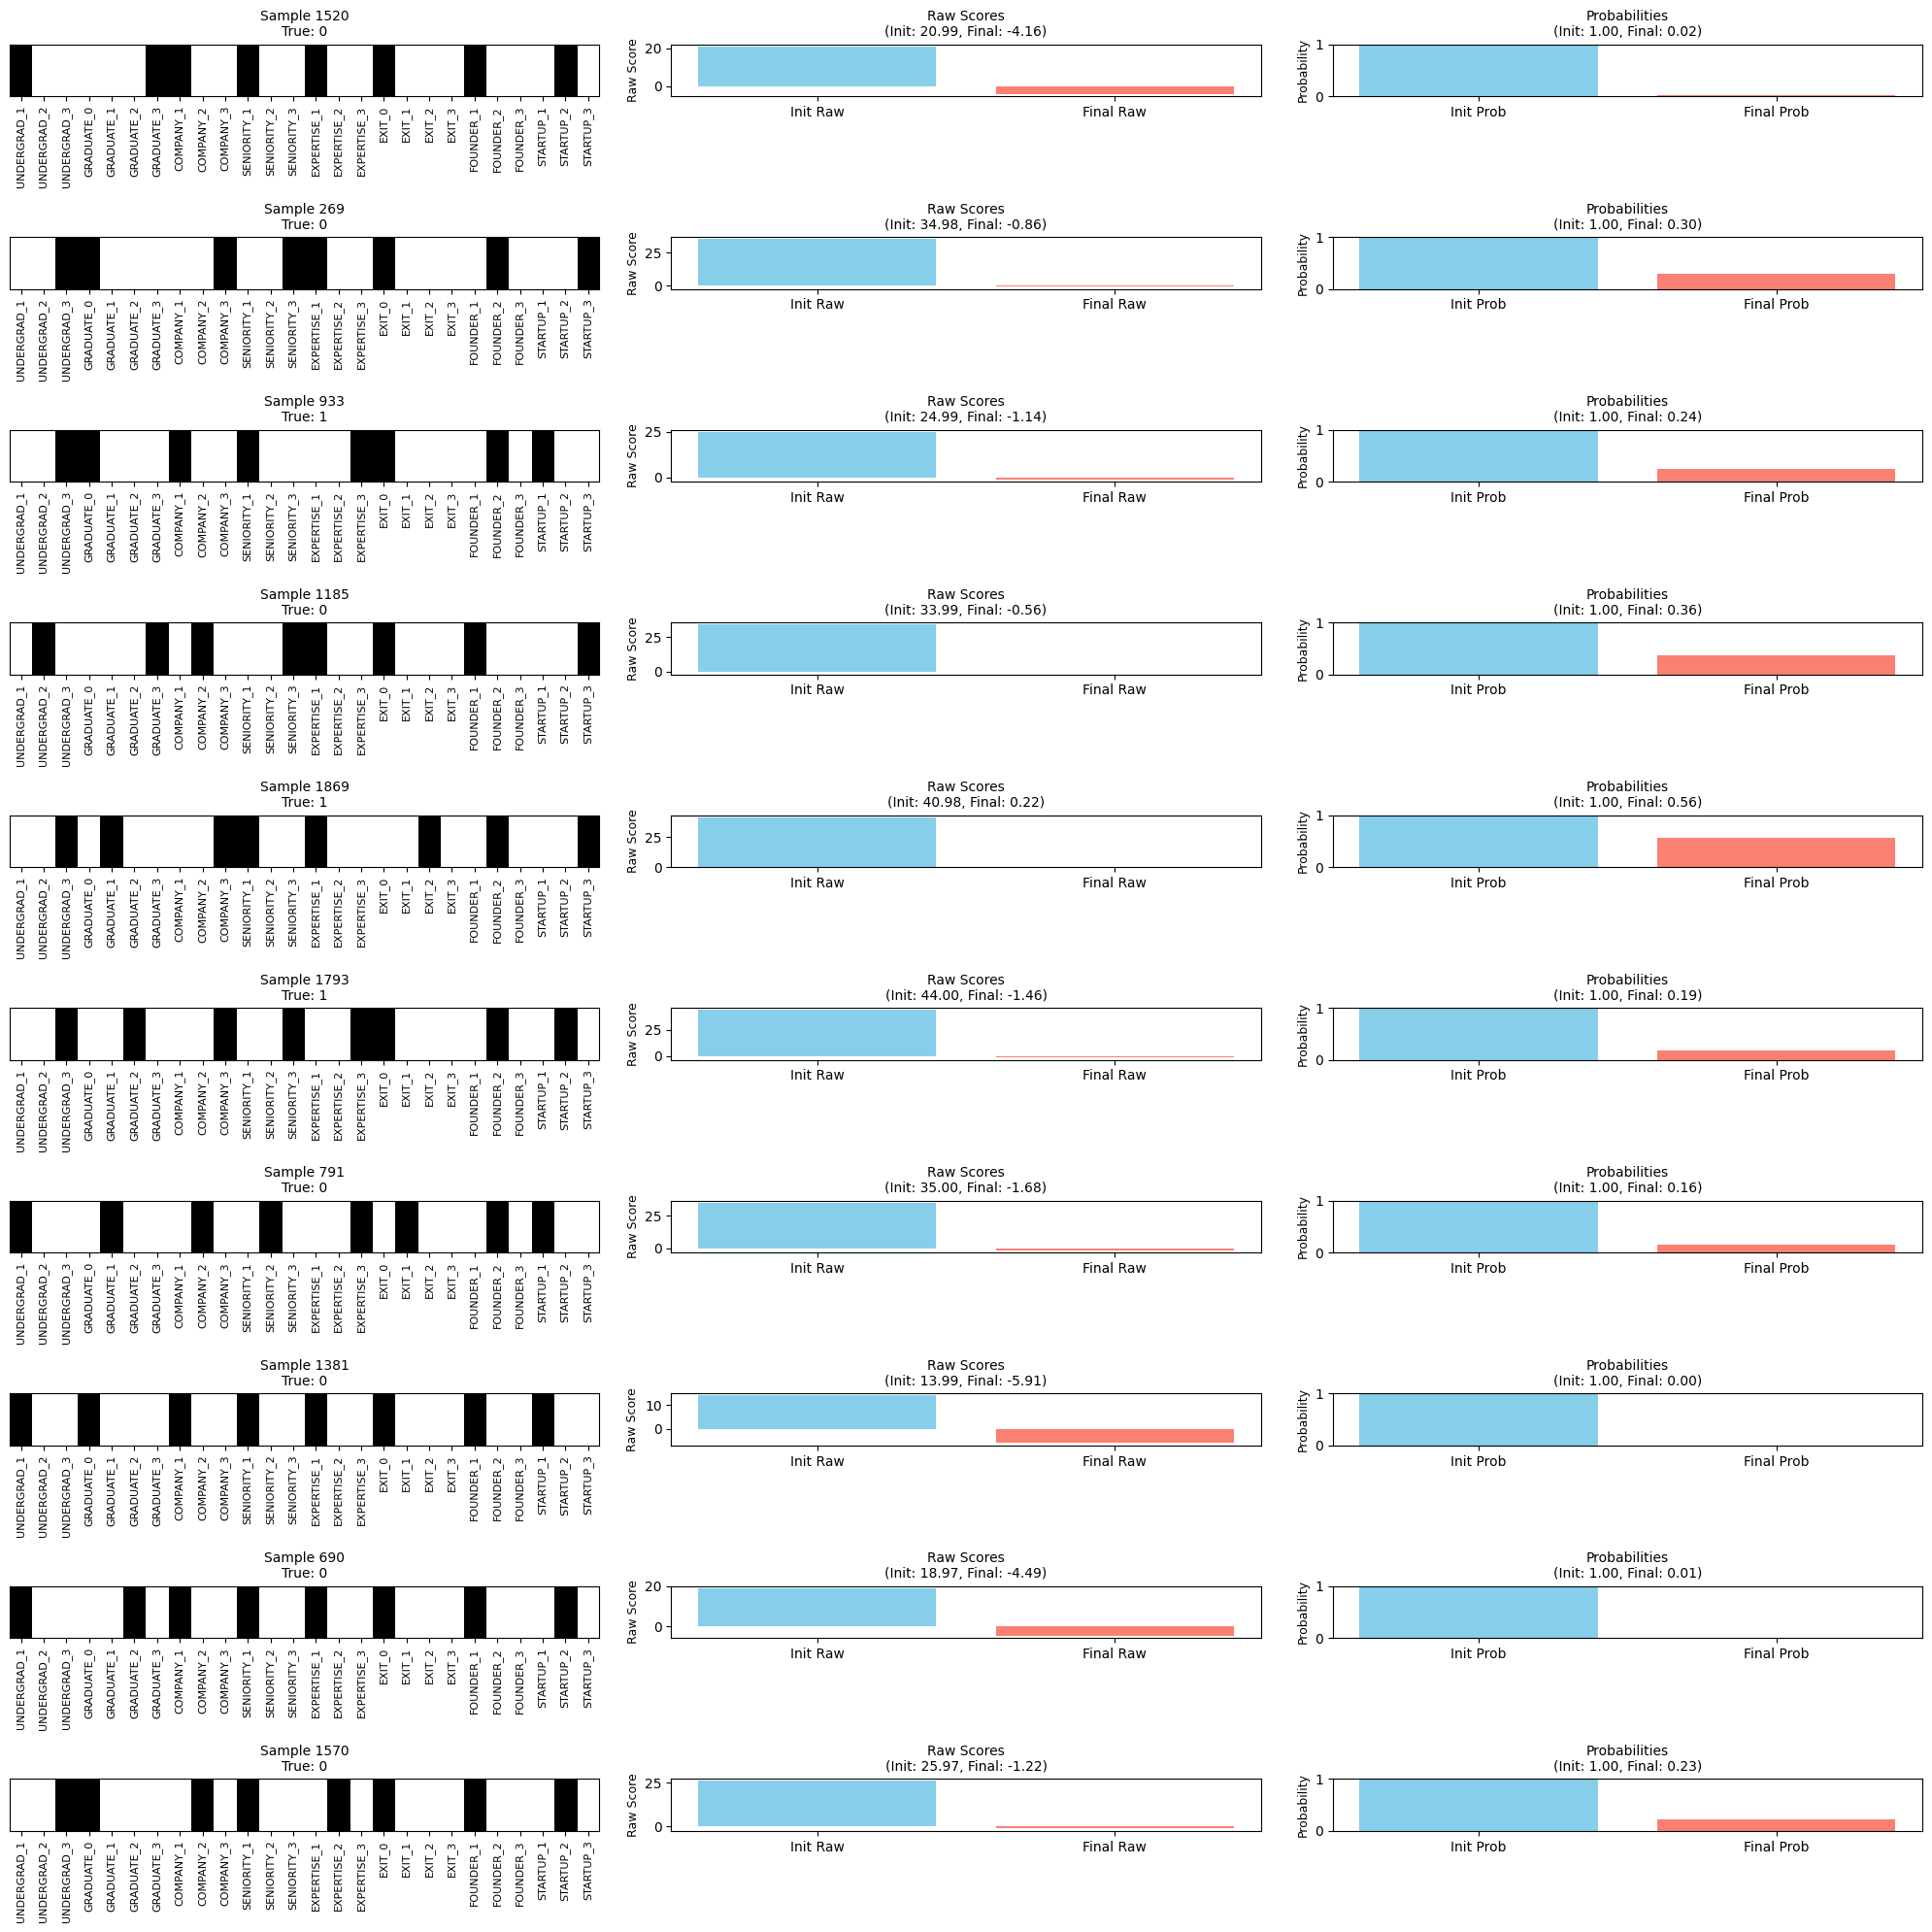

In [46]:
X_raw = df[feature_columns].to_numpy()

X_raw_train, X_raw_test, _, _ = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, shuffle=True
)

n_samples = 10
selected_indices = np.random.choice(len(X_test), size=n_samples, replace=False)
selected_samples = X_test[selected_indices]
selected_y_true = y_test[selected_indices]
selected_raw_attributes = X_raw_test[selected_indices]

raw_scores_init = np.array([x.T @ W_init @ x for x in selected_samples])
raw_scores_final = np.array([x.T @ W @ x + b for x in selected_samples])

p_init = sigmoid(raw_scores_init)
p_final = sigmoid(raw_scores_final)

fig, axs = plt.subplots(n_samples, 3, figsize=(20, 2 * n_samples))
if n_samples == 1:
    axs = axs[np.newaxis, :]

for i in range(n_samples):
    ax_attr = axs[i, 0]
    sample_data = selected_raw_attributes[i].reshape(1, -1)
    im = ax_attr.imshow(sample_data, cmap='Greys', aspect='auto')
    ax_attr.set_yticks([])
    ax_attr.set_xticks(np.arange(len(feature_columns)))
    ax_attr.set_xticklabels(feature_columns, rotation=90, fontsize=8)
    ax_attr.set_title(f"Sample {selected_indices[i]}\nTrue: {selected_y_true[i]}", fontsize=10)
    
    ax_raw = axs[i, 1]
    categories = ['Init Raw', 'Final Raw']
    raw_vals = [raw_scores_init[i], raw_scores_final[i]]
    ax_raw.bar(categories, raw_vals, color=['skyblue', 'salmon'])
    ax_raw.set_ylabel("Raw Score", fontsize=9)
    ax_raw.set_title(f"Raw Scores\n(Init: {raw_scores_init[i]:.2f}, Final: {raw_scores_final[i]:.2f})", fontsize=10)
    
    ax_prob = axs[i, 2]
    prob_categories = ['Init Prob', 'Final Prob']
    prob_vals = [p_init[i], p_final[i]]
    ax_prob.bar(prob_categories, prob_vals, color=['skyblue', 'salmon'])
    ax_prob.set_ylim(0, 1)
    ax_prob.set_ylabel("Probability", fontsize=9)
    ax_prob.set_title(f"Probabilities\n(Init: {p_init[i]:.2f}, Final: {p_final[i]:.2f})", fontsize=10)

plt.tight_layout()
plt.show()